In [27]:
import numpy as np
import matplotlib.pyplot as plt
import niceplots as nicepl
from scipy.stats import gaussian_kde

In [2]:
nicepl.initPlot()

In [6]:
# load data
chain=np.load("posterior_blind_0.npz")['samples']

In [8]:
chain.shape

(41000, 3)

In [9]:
Nparams=chain.shape[1]

In [23]:
param_names=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]

priors={
    r"$\theta_1$": [0.64, 1.035],
    r"$\theta_2$": [0.23008603805291986, 0.39969071100893877],
    r"$\theta_3$": [-1.5, 1.5],
}

In [ ]:
def add_contour(ax, x, y, priorsX, priorsY, color='k', probs=np.array([0.68, 0.95, 0.997]), alpha_min=0.1, alpha_max=0.8):
    
    # 2D KDE
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
            
    # Grid for evaluation
    xgrid = np.linspace(priorsX[0], priorsX[1], 100)
    ygrid = np.linspace(priorsY[0], priorsY[1], 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Compute contour levels for 1σ, 2σ, 3σ
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    dz = (xgrid[1] - xgrid[0]) * (ygrid[1] - ygrid[0])  # grid area element
    cumsum = np.cumsum(Z_sorted*dz)
    cumsum /= cumsum[-1]

    levels = []
    for p in probs:
        idx = np.searchsorted(cumsum, p)
        levels.append(Z_sorted[idx])

    levels=sorted(levels)
            
    alphas = np.linspace(alpha_min, alpha_max, len(levels))

    # Plot from outermost to innermost
    for k in range(len(levels)):
        high=Z.max()
        low=levels[k]
        ax.contourf(X, Y, Z, levels=[low, high], colors=color, alpha=alphas[k])

In [ ]:
def add_hist(ax, x, priorsX, color='k', alpha=1.0):
    # 1D KDE
    kde = gaussian_kde(x)
    
    # Grid for evaluation
    xgrid = np.linspace(priorsX[0], priorsX[1], 100)
    Z = kde(xgrid)

    # Compute contour levels for 1σ, 2σ, 3σ
    Z_flat = Z.flatten()
    Z_sorted = np.sort(Z_flat)[::-1]
    dz = (xgrid[1] - xgrid[0])  # grid area element
    cumsum = np.cumsum(Z_sorted*dz)
    cumsum /= cumsum[-1]

    ax.plot(xgrid, Z, color=color, alpha=alpha)

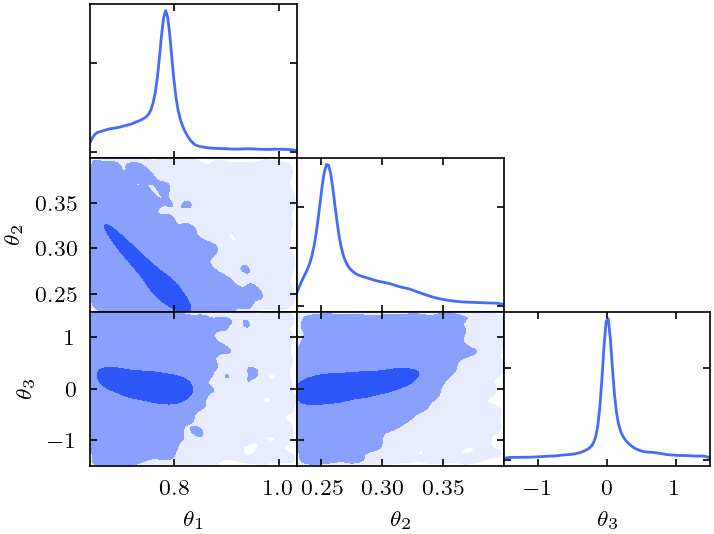

In [ ]:
color='C0'


fig, axs = plt.subplots(Nparams, Nparams)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(Nparams):
    y=chain[:,i]
    y_par_name=param_names[i]
    y_prior=priors[y_par_name]

    for j in range(Nparams):
        x=chain[:,j]
        x_par_name=param_names[j]
        x_prior=priors[x_par_name]
        
        # Set axis limits
        axs[i, j].set_xlim(x_prior[0], x_prior[1])
        
        if i!=j:
            axs[i, j].set_ylim(y_prior[0], y_prior[1])

        # Set axis labels
        if (i==Nparams-1):
            axs[i, j].set_xlabel(x_par_name)
        else:
            axs[i, j].set_xticklabels([])

        if (j==0) and  (i!=0):
            axs[i, j].set_ylabel(y_par_name)
        else:
            axs[i, j].set_yticklabels([])

        # Do plots
        if i == j:
            add_hist(axs[i, j], y, y_prior, color=color)
        elif i>j:
            add_contour(axs[i, j], x, y, x_prior, y_prior, color=color)

        else:
            axs[i,j].axis("off")



In [82]:
np.linspace(0.1, 0.8, 3)

array([0.1 , 0.45, 0.8 ])

In [83]:
0.1+0.45+0.8

1.35